In [1]:
import cv2
import numpy as np
from PIL import Image
from IPython.display import display

In [2]:
def align(h):
    h = h.reshape((4,2))
    hnew = np.zeros((4,2),dtype = np.float32)

    add = h.sum(1)
    hnew[0] = h[np.argmin(add)]
    hnew[2] = h[np.argmax(add)]

    diff = np.diff(h,axis = 1)
    hnew[1] = h[np.argmin(diff)]
    hnew[3] = h[np.argmax(diff)]
    return hnew


In [3]:
def check(h):
	print (h)
	for i in range(len(h)):
		for j in range(len(h)):
			if h[i][0][0]==h[j][0][0] and  h[i][0][1]==h[j][0][1]:
				return 0
	return 1

In [4]:
def view(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))


In [285]:
image=cv2.imread("WA7.jpeg")   #read in the image
print(image.shape)
image=cv2.resize(image,(360,640)) #resizing because opencv does not work well with bigger images
orig=image.copy()
# print (dtype(image))
print (type(image))
# view("img",image)

gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  #RGB To Gray Scale

blurred=cv2.GaussianBlur(gray,(3,3),3)  #(5,5) is the kernel size and 0 is sigma that determines the amount of blur



edged=cv2.Canny(blurred,0,255)  #30 MinThreshold and 50 is the MaxThreshold
# view("Canny",edged)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

opening = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

(1280, 960, 3)
<class 'numpy.ndarray'>


In [286]:
contours,hierarchy=cv2.findContours(opening,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  #retrieve the contours as a list, with simple apprximation model

# print(len(contours))

contours=sorted(contours,key=cv2.contourArea,reverse=True)

if len(contours)>600:
	blurred=cv2.GaussianBlur(gray,(3,3),2)
	# view("blur2",blurred)
	edged=cv2.Canny(blurred,0,255)  
	dil = cv2.dilate(edged, kernel, iterations = 10)
	# view("Canny1",dil)
	contours,hierarchy=cv2.findContours(dil,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  #retrieve the contours as a list, with simple apprximation model
contours=sorted(contours,key=cv2.contourArea,reverse=True)

In [287]:
max_=0
#the loop extracts the boundary contours of the page
for c in contours:
    # print (c)
    p=cv2.arcLength(c,True)
    approx=cv2.approxPolyDP(c,0.01*p,True)
    print (cv2.contourArea(c))

    # print (approx,cv2.contourArea(c))
    if len(approx)<9 and cv2.contourArea(c)> 400 and len(approx)>=4:
        target=approx
        break

36462.0


In [288]:
polygon = []
poly = []
x = []
y = []
for i in approx:
    polygon.append(tuple(i[0]))
    poly.append((i[0]))
    x.append(i[0][0])
    y.append(i[0][1])


print (x,y)

[49, 49, 61, 98, 133, 132, 84] [157, 573, 591, 598, 579, 162, 174]


In [289]:
box = []
# box.append((min(x),min(y)))
# box.append((min(x),max(y)))
# box.append((max(x),max(y)))
# box.append((max(x),min(y)))
# print (box)

y_mean = sum(y)//len(x)
y_up = max(y)
y_down = min(y)
for val in y:
    print (val)
    if val>y_mean and y_up>val:
        y_up = val
    if val<y_mean and y_down<val:
        y_down = val 

box.append((min(x),y_down))
box.append((min(x),y_up))
box.append((max(x),y_up))
box.append((max(x),y_down))

157
573
591
598
579
162
174


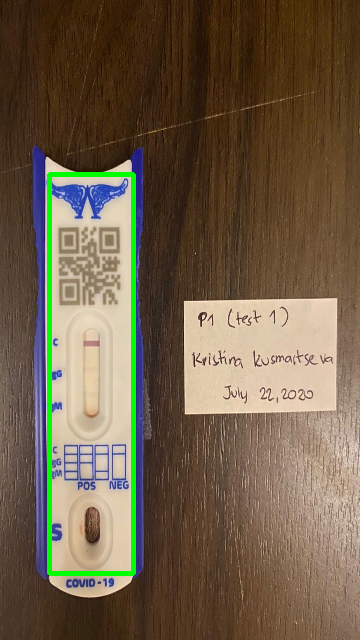

In [290]:
for i in range(len(box)-1):
    cv2.line(image,box[i],box[i+1],(0, 255, 0),3)
cv2.line(image,box[i+1],box[0],(0, 255, 0),3)
view(image)

[[49, 174], [49, 573], [133, 573], [133, 174]]


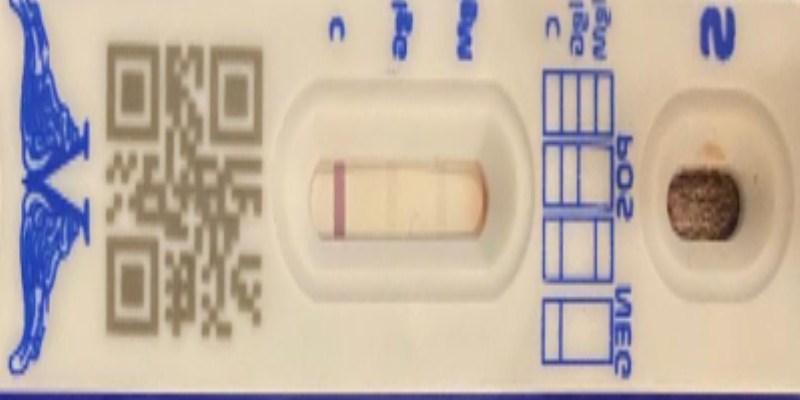

In [291]:
x =300
boxplot = []
for pt in box:
    boxplot.append(list(pt))
print (boxplot)
boxplot = np.float32(np.array(boxplot))
pts=np.float32([[0,0],[800,0],[800,400],[0,400]])  #map to 800*800 target window
# # print (approx)
# for points in list(box):
# 	orig = cv2.circle(orig, tuple(points), 3, (0,255,0), 2)
# view("dot",orig) 
op=cv2.getPerspectiveTransform(boxplot,pts)  #get the top or bird eye view effect
dst=cv2.warpPerspective(orig,op,(800,400))
view(dst)

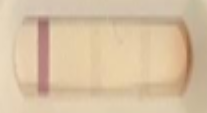

In [292]:

img = np.zeros([dst.shape[0],dst.shape[1],3],dtype=np.uint8)
# img = [[1]*dst.shape[1]]*dst.shape[0]
color = (255,255,255)
xmin = dst.shape[1]//3 + 30
ymin = dst.shape[0]//3 + 10
xmax = dst.shape[1]*2//3 - 30
ymax = dst.shape[0]*2//3 - 10
img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),color,thickness = -1)
src = cv2.bitwise_and(dst, img)
# img = np.array(img,dtype=np.uint8)
# view(src)

reading = np.float32(np.array([[xmin,ymax],[xmax,ymax],[xmax,ymin],[xmin,ymin]]))
pts=np.float32([[0,0],[xmax-xmin,0],[xmax-xmin,ymax-ymin],[0,ymax-ymin]])  #map to 800*800 target window
op=cv2.getPerspectiveTransform(reading,pts)  #get the top or bird eye view effect
dst1=cv2.warpPerspective(src,op,(xmax-xmin,ymax-ymin))
view(dst1)


In [304]:
gray=cv2.cvtColor(dst1,cv2.COLOR_BGR2GRAY)  #RGB To Gray Scale
kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
im = cv2.filter2D(gray, -1, kernel)
edged=cv2.Canny(im,100,300)  #30 MinThreshold and 50 is the MaxThreshold
# view(edged)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (12,12))

opening = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

# view(opening)




contours,hierarchy=cv2.findContours(opening,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)  #retrieve the contours as a list, with simple apprximation model

vote0 = len(contours) - 1
print(vote0)

1


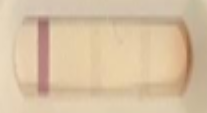

In [305]:
orb = cv2.ORB_create()
# print (3)
# view('img',img)
img = dst1
# find the keypoints with ORB
kp = orb.detect(img,None)
# print (4)
# compute the descriptors with ORB
# print (kp)
kp, des = orb.compute(img, kp)
# print (5)
# print (kp)
# draw only keypoints location,not size and orientation
img2 = cv2.drawKeypoints(img,kp,outImage=img,color=(0,255,0), flags=0)
# plt.imshow(img2),plt.show()

view(img2)

In [306]:
def find_peak(array):
#This function has the algorithm to find the peaks in fourier transform of the audio array
    length = len(array)
    cnt=[]
    flag= -1
    var=0
    imax =0
    for i in range(1,length):
            if array[i-1]<array[i]:
                if flag == -1:
                    flag = 1
            if array[i-1]>array[i]:
                if flag == 1:
                    flag = -1
                    cnt.append(i-1)
    if len(cnt)==1:
        imax = cnt[0]
    else:
        maxm = np.max(array)
        mid = maxm/8
        for i in range(0, len(cnt)):
            if array[cnt[i]] > mid:
                imax = cnt[i]
                break
    return cnt

In [307]:
def verSum(img):
    img = 255-img
#     th = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_row_sum = np.sum(img_gray,axis=1).tolist()
    view(img)
    return img_row_sum

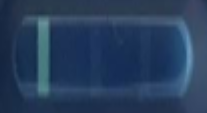

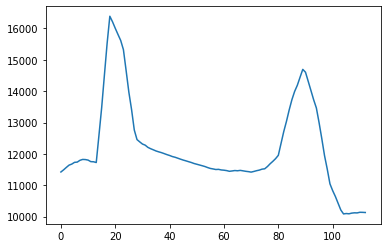

[8, 18, 58, 64, 66, 89, 105, 108, 110]

In [308]:
from matplotlib import pyplot as plt
row_sum = verSum(img)
# print (row_sum)
peak = find_peak(row_sum)
n = len(row_sum)
plt.plot(row_sum)
plt.show()
mean = sum(row_sum)//n
peak


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
[15, 24] 1


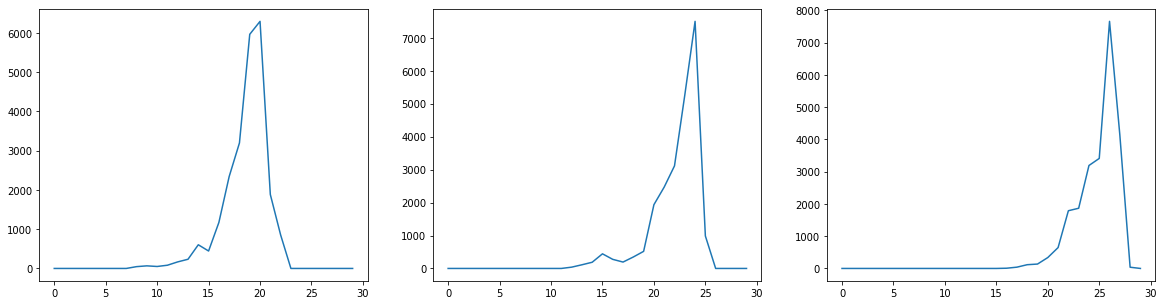

In [309]:
from matplotlib import pyplot 
fig, axes = pyplot.subplots(1, 3, sharex=True, figsize=(20,5))
print (axes)
hist1 = cv2.calcHist([img],[0],None,[30],[0,255])
axes[0].plot(hist1)
hist2 = cv2.calcHist([img],[1],None,[30],[0,255])
axes[1].plot(hist2)
hist3 = cv2.calcHist([img],[2],None,[30],[0,255])
axes[2].plot(hist3)

peak = find_peak(hist2)
vote1 = len(peak) -1
print (peak,vote1)


In [311]:
if vote0 == vote1:
    print ("Number of lines in the meter are",vote0)
else:
    print ("According to the two analysis we have 2 votes")
    print (vote0,"And",vote1)
    print ("According")

Number of lines in the meter are 1
